# (02) Intrinsic analysis of cycling network data

**Input files of this notebook:**
* '../config.yml'
* '../data/osm_{study_area}.graphml'
* '../data/osm_{study_area}_simple.graphml'
* '../data/grid_{study_area}.gpkg'

**Output files of this notebook:**
* '../results/osm_instrinsic_analysis_{study_area}.json'
* '../results/grid_results_intrinsic_{study_area}.pickle'


This notebook analyses the quality of OSM data on cycling infrastructure for a given area. 

The purpose of the evaluation is specifically to assess the fitness for use of OSM data for cycling research, particularly research projects based around network analysis, in which the topology of the geometries are of particular importance.

The notebook makes use of quality metrics previously used by a range of previous projects investigating OSM/VGI data quality, such as **XXXXXX (OBS! Add references here.)**

Since the assesment do not make use of an external reference dataset as the ground truth, no universal claims of data quality can be made. 
The idea is rather to enable the those working with cycling networks based on OSM to assess whether the data is good enough for their particular usecase.

The various steps in the analysis thus attempts to highlight issues that might undermine the quality of analyses based on the data, but leaves the final interpretation of the results to the end user.

For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.

**Sections:**

1. Load and process data
2. Data completeness
    - Network density (nodes and edges)
3. OSM Tag Analysis
    - Missing Tags
    - Incompatible Tags
    - Tagging Patterns
4. Network Topology
    - Simplification outcomes: duplicated geometries **(OBS! Missing!!)** 
    - Dangling nodes
    - Overshoots 
    - Undershoots
    - Missing intersections
5. Network components
6. Save results
7. *Contributor Data Analysis (work in progress)*
****

## 1. Load and process data

In [11]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
from src import evaluation_functions as ef

### Load settings

In [12]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    
print('Settings loaded!')

Settings loaded!


### Load OSM graphs and grid

*(this data is prepared in the 'load_data' notebook)*

In [14]:
# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(
    f'../data/osm_{study_area}.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

osm_simplified_graph = ox.load_graphml(
    f'../data/osm_{study_area}_simple.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

# Convert to nodes and edges
nodes, edges = ox.graph_to_gdfs(osm_graph)
simplified_nodes, simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# convert lengths to float
simplified_edges["infrastructure_length"] = simplified_edges["infrastructure_length"].astype(float)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

#Joining grid cell id to network elements and counting features in each grid
s_edges_join = gpd.overlay(simplified_edges, grid, how ='intersection')
edges_join = gpd.overlay(edges, grid, how='intersection')

s_nodes_join = gpd.overlay(simplified_nodes, grid, how ='intersection')
nodes_join = gpd.overlay(nodes, grid, how='intersection')

s_edges_join['length'] = s_edges_join['geometry'].length
s_edges_join['infrastructure_length'] = s_edges_join.apply(
    lambda x: ef.measure_infrastructure_length(
        edge = x.geometry, 
        geometry_type=x.cycling_geometries, 
        bidirectional=x.cycling_bidirectional, 
        cycling_infrastructure=x.cycling_infrastructure), 
    axis=1)

# Count features in each grid cell
all_data = [edges_join, nodes_join, s_edges_join, s_nodes_join]
labels = ['edges','nodes','simplified_edges','simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how = 'left')

print('Data loaded!')

Data loaded!


__________________

## 2. Data completeness

### Network Density

#### Why?

#### How?

#### What could it mean?

Network density without comparing to a reference dataset does not in itself indicate spatial data quality. 

For anyone familiar with the study area, network density can however indicate whether parts of the area appear to be under- or overmapped, and is thus included here.

The density here is not based on the geometric length of edges, but instead on the computed length of the infrastructure. For example, a 100 meter long bidirectional path contributes with 200 meters of cycling infrastructure.

For the entire study area, there are:
- 5877.13 meters of cycling infrastructure per square km
- 26.14 nodes in the cycling network per square km
- 9.89 dangling nodes in the cycling network per square km


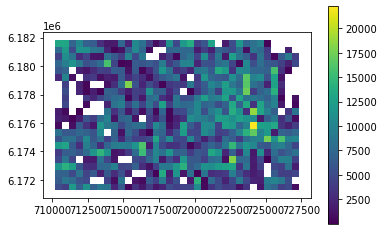

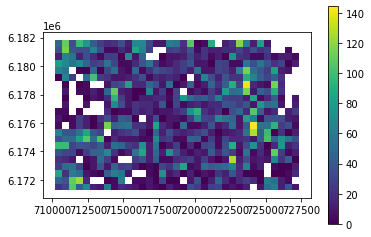

In [15]:
# Entire study area
edge_density, node_density, dangling_node_density = ef.compute_network_density(
    (simplified_edges, simplified_nodes),
    grid.unary_union.area, 
    return_dangling_nodes=True)

density_results = {}
density_results['edge_density'] = edge_density
density_results['node_density'] = edge_density
density_results['danling_node_density'] = dangling_node_density

print(f'For the entire study area, there are:')
print(f'- {edge_density:.2f} meters of cycling infrastructure per square km')
print(f'- {node_density:.2f} nodes in the cycling network per square km')
print(f'- {dangling_node_density:.2f} dangling nodes in the cycling network per square km')

# Per grid cell
results_dict = {}
data = (s_edges_join, s_nodes_join)

[ef.run_grid_analysis(
    grid_id, data, 
    results_dict, 
    ef.compute_network_density, 
    grid['geometry'].loc[grid.grid_id==0].area[0]) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'edge_density',1:'node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='edge_density', legend=True)
grid.plot(column='node_density', legend=True);

______________________

## 3. OSM tag analysis

For cycling research, we are often interested in more information than just the presence of cycling infrastructure.

Informatiob about e.g. the width of the infrastructure, speedlimits, street lights etc. are also important when for example evaluating the bikefriendliness of an area or individual network segment.

The presence of these tags is however highly uneven in OSM, which poses a barrier to evaluations of bikeability and traffic stress. Likewise, the lack of restrictions on how OSM features can be tagged sometimes result in conflicting tags, which undermines the evaluation of cycling conditions.

Below is an evaluation of the presence of tags of common relevance to cycling research and planning.

Note that for the evaluation of tags, the unsimplified edges should be used to avoid issues with tags that have been aggregated in the simplification process.

Examples of evaluations of missing tags in OSM can for example be found in **XXXX (OBS! add reference)**

**TDAV shorten description above (fit parts of it with the corresponding sub-part of tag analsyis)**

1. Missing tags
2. Incompatible tags
3. Tagging patterns

### Missing tags

*Computing number of edges with a defined value for important tags.*

#### Why?

#### How?

#### What could it mean?

In [4]:
print(f'Analysing tags describing:')
[print(key) for key, _ in missing_tag_dict.items()]

existing_tags_results = ef.analyse_missing_tags(edges, missing_tag_dict)

for key, value in existing_tags_results.items():
    print(f'In the entire dataset, {value} edges or {value/len(edges)*100:.2f} % have information about: {key}')

results_dict = {}
[ef.run_grid_analysis(grid_id, edges_join, results_dict, ef.analyse_missing_tags, missing_tag_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
cols = results_df.columns
new_cols = ['existing_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['existing_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

for c in new_cols:
    grid[c+'_pct'] = round(grid[c] / grid.count_edges * 100,2)

existing_tags_pct = {}

for k, v in existing_tags_results.items():
    existing_tags_pct[k+'_pct'] = v / len(edges) * 100

existing_tags_results = dict(existing_tags_results, **existing_tags_pct)

Analysing tags describing:
surface
width
speedlimit
lit
In the entire dataset, 1288 edges or 4.16 % have information about: surface
In the entire dataset, 644 edges or 2.08 % have information about: width
In the entire dataset, 16556 edges or 53.49 % have information about: speedlimit
In the entire dataset, 24132 edges or 77.97 % have information about: lit


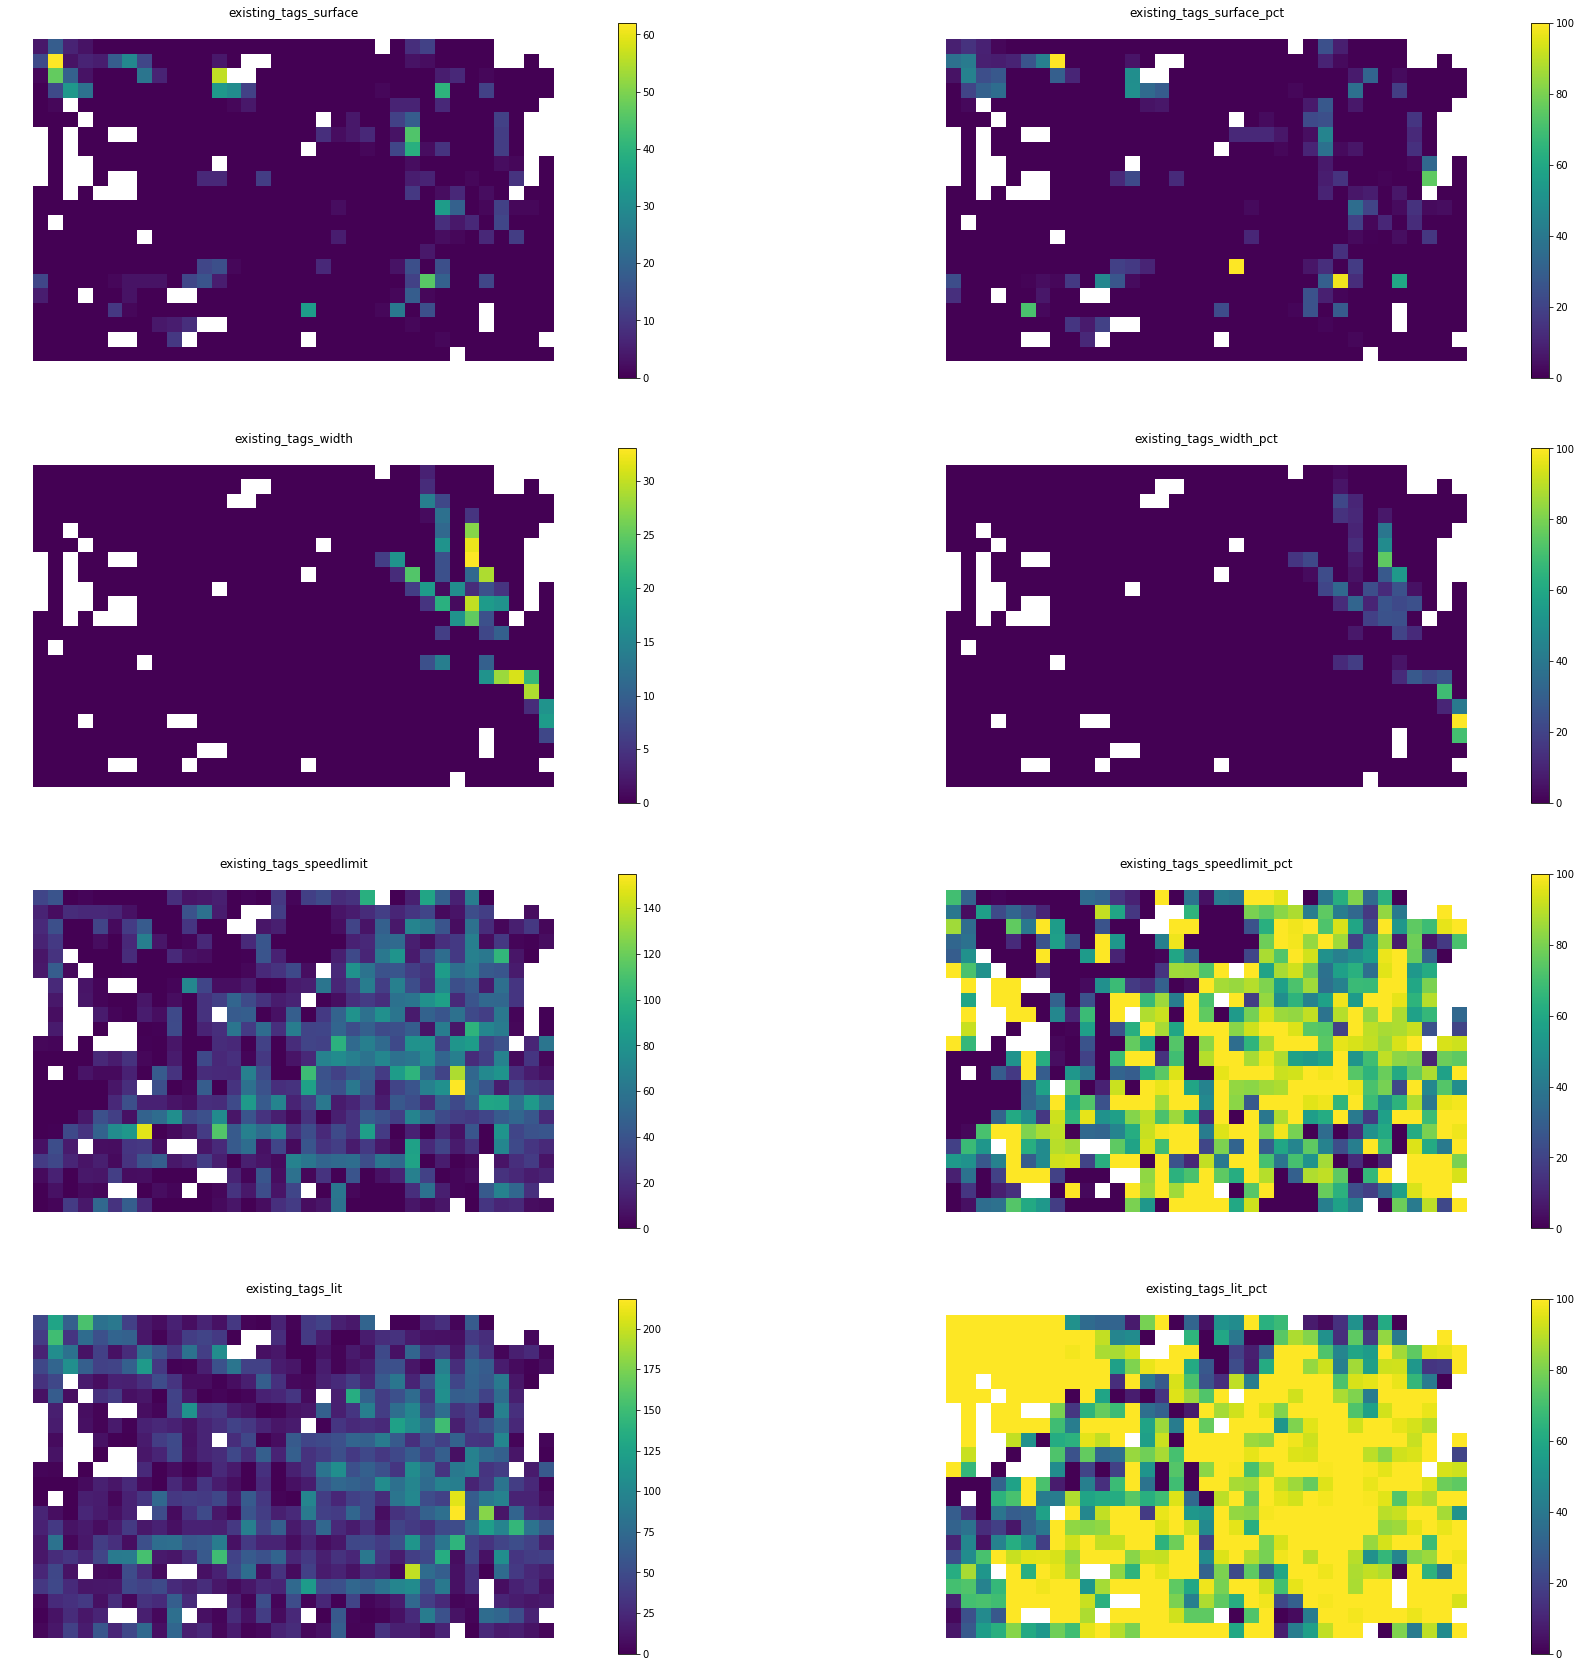

In [5]:
#  TODO: Format plotting 
fig, axes = plt.subplots(nrows=len(new_cols), ncols=2, figsize=(30,30))

for i,c in enumerate(new_cols):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    grid.plot(ax=ax1, column=c, legend=True)
    grid.plot(ax=ax2, column=c+'_pct', legend=True)

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.set_title(c)
    ax2.set_title(c+'_pct')

### Incompatible tags

*Checking for incompatible tags:*

#### Why?

#### How?

#### What could it mean?

In [6]:
incompatible_tags_results = ef.check_incompatible_tags(edges, incompatible_tags_dict)

print(f'In the entire dataset, there are {sum(incompatible_tags_results.values())} incompatible tag combinations (of those defined)')

results_dict = {}
[ef.run_grid_analysis(
    grid_id, 
    edges_join, 
    results_dict, 
    ef.check_incompatible_tags, 
    incompatible_tags_dict) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')

cols = results_df.columns
new_cols = ['incompatible_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['incompatible_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)
grid = grid.merge(results_df, on='grid_id', how='left')


In the entire dataset, there are 4 incompatible tag combinations (of those defined)


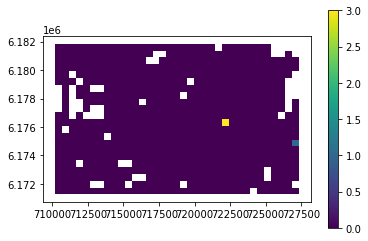

In [7]:
# # TODO: Format plotting -
for key in incompatible_tags_results.keys():
    grid.plot(column='incompatible_tags_'+key, legend=True)

### Tagging patterns

#### Why?

Identifying cycling infrastructuer in OSM can sometimes be complicated, due to the many different ways in which the presence of cycling infrastructure can be indicated. The [OSM Wiki](https://wiki.openstreetmap.org/wiki/Main_Page) is a great resource for recommendations for how OSM features should be tagged, but some inconsistencies and local variations do however remain.

Regardless of how the cycling infrastructure is defined, examining which tags contribute to which parts of the cycling network can be a useful way of visually examining patterns in tagging methods, and whether some elements of the query results in too many or too few features to be included.

Likewise, 'double tagging' where several differnet tags have been used to indicate cycling infrastructure can lead to mis-classifications of the data. In some instances, such as 'cycleway:right' and 'cycleway:left', having data for both tags is valid, but other combinations such as 'cycleway'='track' and 'cycleway:left'=lane gives an ambiguouos picture of what type of cycling infrastructure is present.

For this reason, identifying features that are included in more than one of the queries defining cycling infrastructure can indicate issues with the tagging quality.

#### How?

#### What could it mean?

**Visualising how different elements of the network is tagged:**

In [8]:
edges['tagging_type'] = ''

for k, q in cycling_infrastructure_queries.items():

    try:
        ox_filtered = edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)
    
    edges.loc[ox_filtered.index, 'tagging_type'] = edges.loc[ox_filtered.index, 'tagging_type'].astype(str) + str(k)

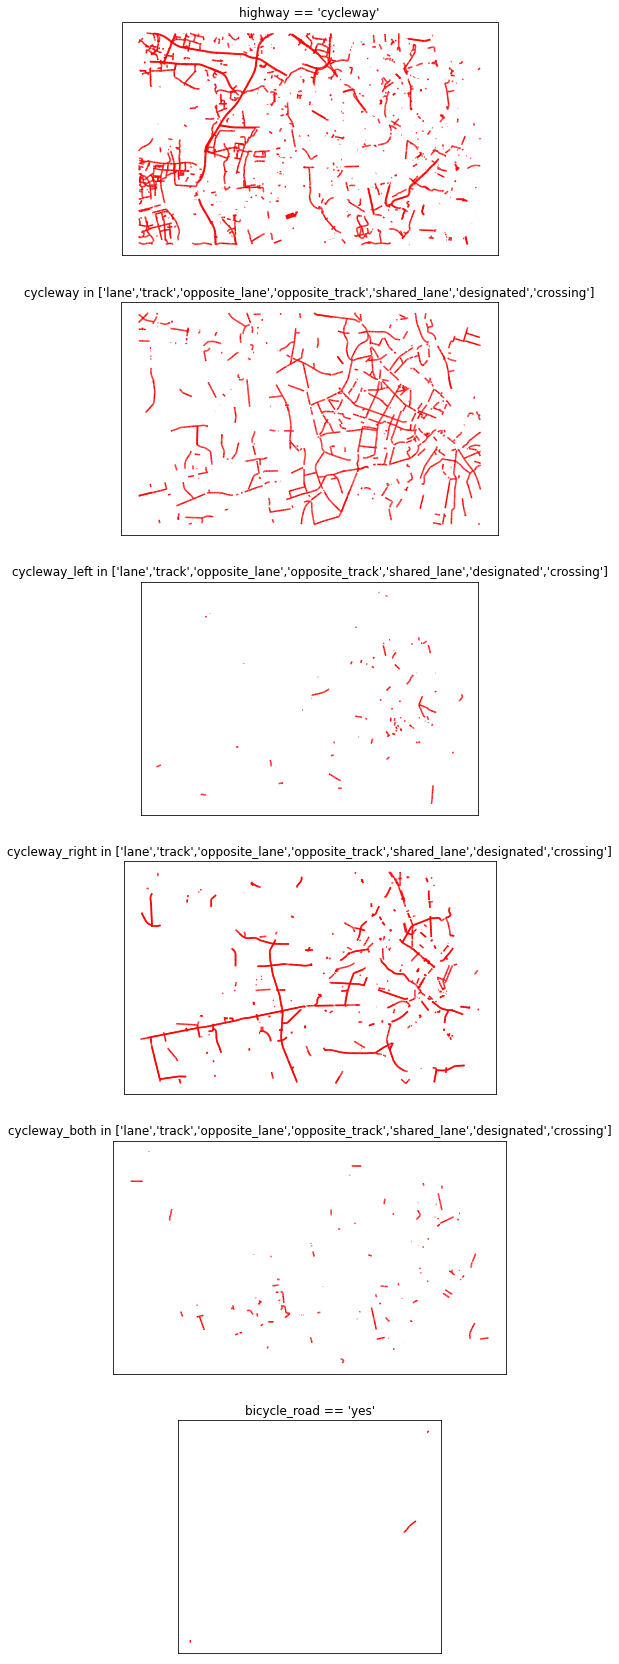

In [10]:
# TODO: fix plots!

# These plots include all edges where the query is true - also those that are true for more than one query
fig, axes = plt.subplots(nrows=len(cycling_infrastructure_queries), ncols=1, figsize=(30,30))

axes = axes.flatten()

for k, q in cycling_infrastructure_queries.items():
    
    ax = axes[k-1]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type'].str.contains(str(k))].plot(ax=ax, color='red')

    ax.set_title(q)

    cx.add_basemap(
        ax=ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )

**Visualising where cycling infrastructure have been tagged in several, potentially competing, ways:**

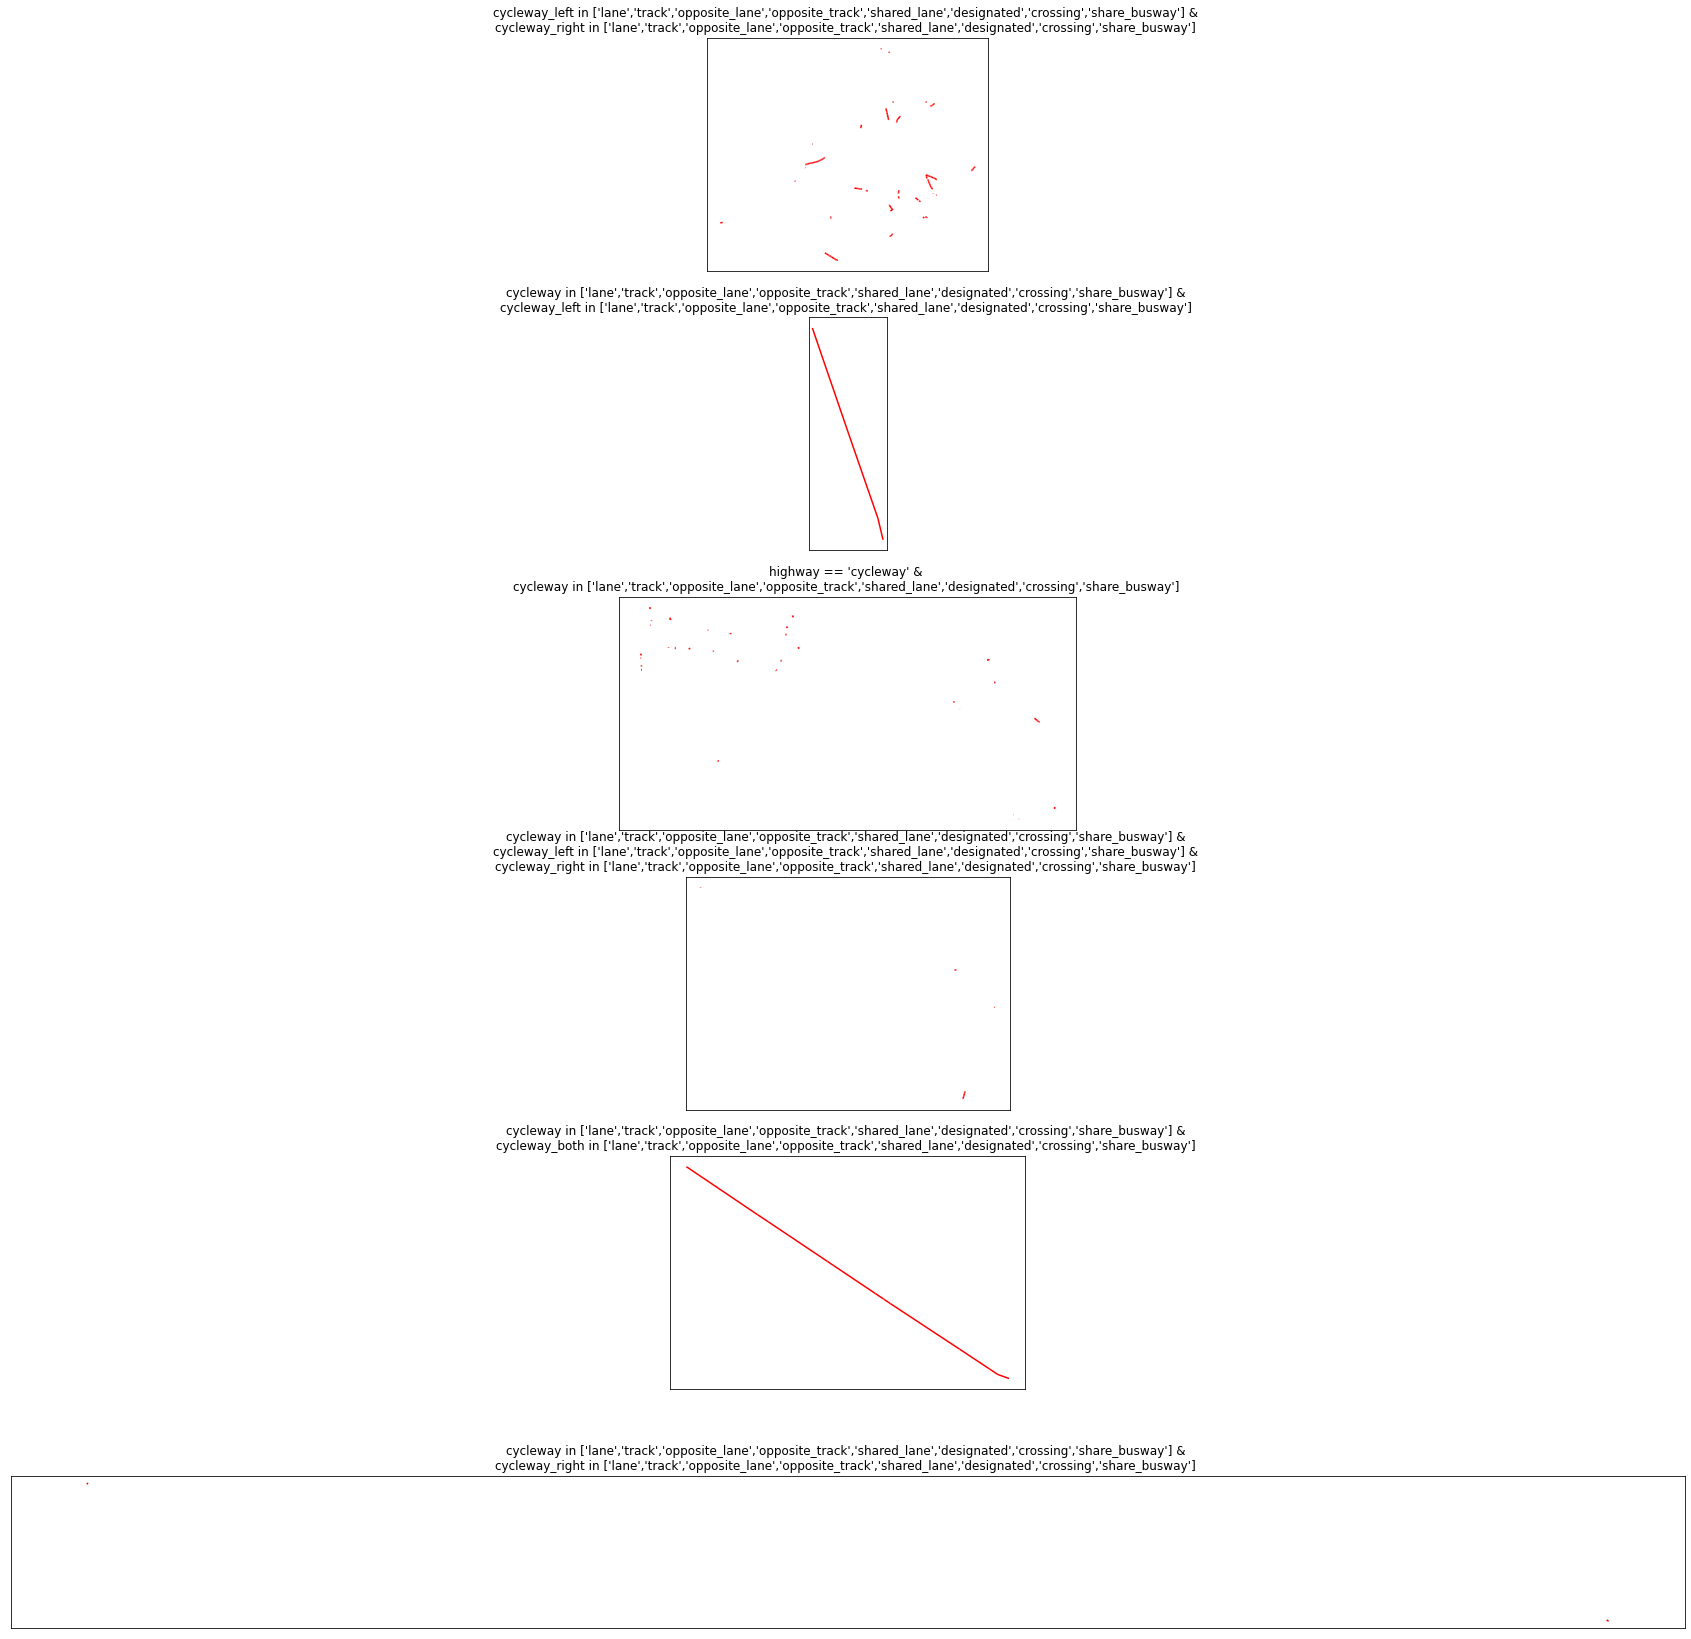

In [ ]:
# TODO: fix plots!

# Plot all edges where tagging_type is more than one letter
tagging_combinations = list(edges.tagging_type.unique())
tagging_combinations = [x for x in tagging_combinations if len(x) > 1]

fig, axes = plt.subplots(nrows=len(tagging_combinations), ncols=1, figsize=(30,30))

axes = axes.flatten()

for i, t in enumerate(tagging_combinations):

    ax = axes[i]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type']==t].plot(ax=ax, color='red')

    # Get queries corresponding to k
    title = ''
    for value in t:
        query = cycling_infrastructure_queries[int(value)]
        title = title + str(query) + ' & \n'
    
    title = title.rsplit('&', 1)[0]
    
    ax.set_title(title)


______________________

## 4. Network topology

This section explores the aspects of the data that relates to the geometric and topological features of the data.

These are e.g. network density, disconnected components, or whether there are nodes in close proximity, that do not share an edge - a potential sign of edge undershoots - or if there are intersecting edges without a node at the intersection, which might indicate a digitizing error that will distort any attempts at routing on the network.

It is important to note that due to the fragmented nature of most networks of cycling infrastructure **OBS REFERENCE HERE** many metrics such as missing links or network gaps simply reflect the true extent of the infrastructure, while they in a car network more readily could be interpreted as an issue with data quality.

We thus at this stage have to restrict ourselves to looking at very small network gaps when looking at cycling infrastructure networks.

TDAV shorten and adjust description

1. Simplification outcomes
2. Network density (nodes and edges)
3. Dangling nodes
4. Network components
5. Snapping issues


### Simplification & graph conversion outcome

#### Why?

#### How?

#### What could it mean?

In order to compare the structure and true ratio between nodes and edges in a network, a simplified network representation which only includes nodes at endpoints and intersections, or where the value of important attributes change, are required.

**OBS: How does simplification results relate to data quality?**

The simplification process for this area resulted in the following reduction of the number of network elements:

In [11]:
edge_percent_diff = (len(edges) - len(simplified_edges)) / len(edges)*100
node_percent_diff = (len(nodes) - len(simplified_nodes)) / len(nodes)*100

simplification_results = {
    'edge_percent_diff': edge_percent_diff,
    'node_percent_diff': node_percent_diff
    }

print(f'Simplifying the network decreased the number of edges with {edge_percent_diff:.1f}% and the number of nodes with {node_percent_diff:.1f}%')

Simplifying the network decreased the number of edges with 82.4% and the number of nodes with 84.5%


### Dangling nodes, under/overshoots and missing intersections

#### Why?

#### How?

#### What could it mean?

A dangling node in a network is all the start and end nodes - in other words, nodes that do not represent intersections between edges, but indicates where an edge begins or ends.

Most networks will naturally contain a number of dangling nodes. How many does to some extent depend on the digitization method (*see illustration below for how the digitization method determines whether a dangling node wil occur.*)

The presence of dangling nodes are thus in itself not a sign of low data quality, but a high number in an area that is not known for suffering from many dead-ends can indicate digitization errors and problems with edge under- and overshoot (see below or GIS Lounge for an [explanation of under- and overshoots](https://www.gislounge.com/digitizing-errors-in-gis/)).

When two nodes in a simplified network are placed within a distance of a few meters, but do not share a common edge, we often have a case of an edge over/under shoot or another digitizing error.

Based on Barron et al., 2013.

- Not always a problem - the feature might play a role - but overshoots can skew the analysis of network structure
- Undershoots a problem for any routing that only considers cycling infrastructure

<img src='../images/dangling_nodes_illustration.png' height=200 />  <img src='../images/no_dangling_nodes_illustration.png' height=200 />

*Dangling nodes occur where road features end (left), but when separate features are joined at the end (right), there will be no dangling nodes*

<img src='../images/overshoot_illustration.png' height=200 />  <img src='../images/undershoot_illustration.png' height=200 />

*Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection (left).* 
*Undershoots happen when two line features are not properly joined, for example at intersection (right)*

#### Dangling nodes

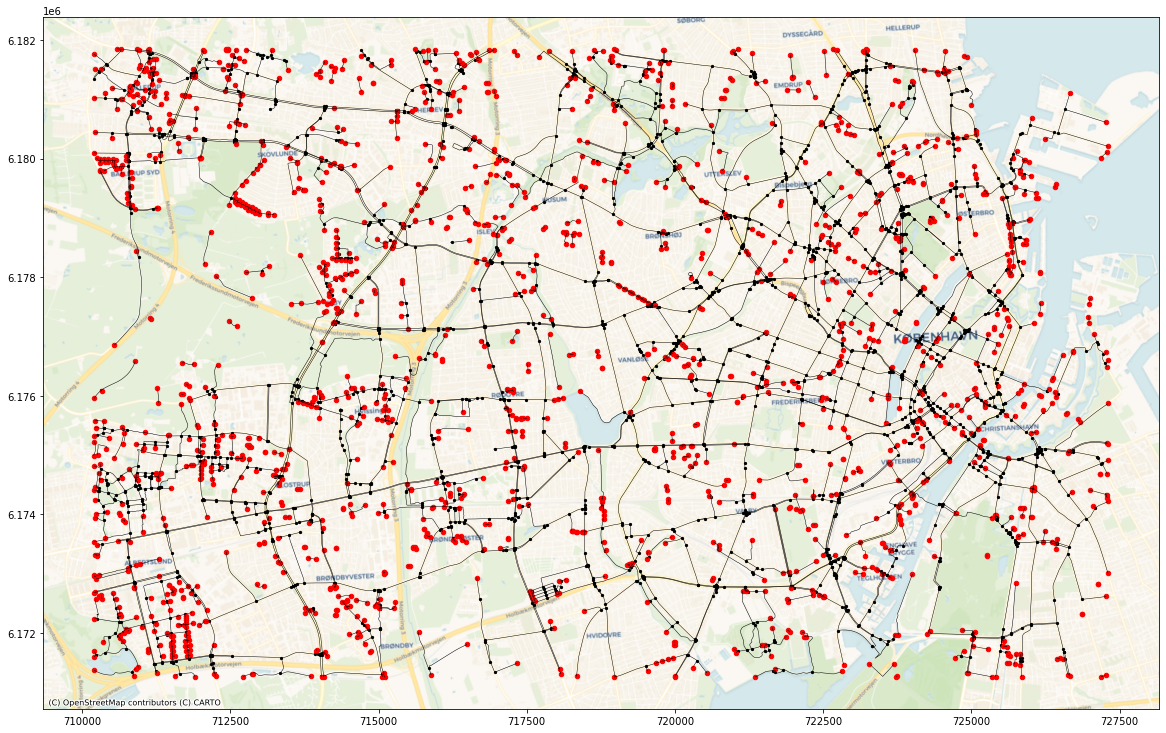

In [5]:
# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

#### Overshoots

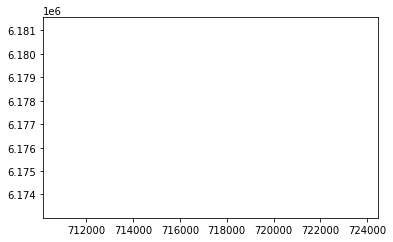

In [8]:
length_tolerance = 3
overshoots = ef. find_overshoots(dangling_nodes, simplified_edges, length_tolerance, return_overshoot_edges=True)

overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

print(f'{len(overshoots)} potential overshoots were identified')

#### Undershoots

12 potential undershoots were identified


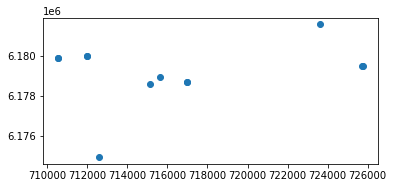

In [15]:
length_tolerance = 3
undershoot_dict, undershoot_nodes = ef.find_undershoots(
    dangling_nodes, 
    simplified_edges, 
    length_tolerance, 
    'edge_id', 
    return_undershoot_nodes=True)

undershoot_nodes.plot();

print(f'{len(undershoot_nodes)} potential undershoots were identified')

# TODO: make folium plt

#### Missing nodes at edge intersections

When two edges intersect without having a node at the intersection - and if neither edges are tagged as a brige or a tunnel - we have a clear indication of a topology error. 

Based on Barron et al., 2013.

In [29]:
edges['intersection_issues'] = edges.apply(lambda x: ef.check_intersection(row = x, gdf=edges), axis=1)

count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

print(f'{count_intersection_issues} edges appear to be missing an intersection node or a bridge/tunnel tag.')

# TODO: Fix plot
if count_intersection_issues > 0:
    edges.loc[(edges.intersection_issues.notna()) & (edges.intersection_issues > 0)].plot()

0 edges appear to be missing an intersection node or a bridge/tunnel tag.


___________________

## 5. Network components

### Disconnected components

#### Why?

#### How?

#### What could it mean?

Disconnected components are parts of the network which - as the name indicates - are disconnected. It is thus not possible to move from one component to the other.

As mentioned above, most real-world networks of cycling infrastructure do consist of many disconnected components **OBS: Ref here**, but when two disconnected components are places very close togehter, it might be a sign of a missing edge or another digitizing error.

**Number of connected components:**

In [ ]:
components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} disconnected components.')

components_plot = ef.plot_components(components)

**Distribution of network length per component:**

In [ ]:
components_length = {}

for i, c in enumerate(components):

    c_length = 0

    for (u, v, l) in c.edges(data='length'):

        c_length += l
        
    components_length[i] = c_length

components_df = pd.DataFrame.from_dict(components_length, orient='index')

components_df.rename(columns={0:'component_length'}, inplace=True)

ax = components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (10,10))

# TODO: Format plot. Convert axes to km

In [ ]:
largest_cc = max(components, key=len)

largest_cc_length = 0

for (u, v, l) in largest_cc.edges(data='length'):

        largest_cc_length += l

largest_cc_pct = largest_cc_length / components_df['component_length'].sum() * 100

print(f'The largest connected component contains {largest_cc_pct:.2f} % of the network length.')

**Identifying disconnected components with less than ten meters between them:**

In [ ]:
component_issues, component_edges = ef.find_adjacent_components(
    components=components, 
    buffer_dist=10, 
    crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

simplified_edges.plot(ax=ax, color='grey')
component_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with uconnected components as well

In [ ]:
components_results = {}
components_results['component_count'] = len(components)
components_results['largest_cc_pct_size'] = largest_cc_pct
components_results['largest_cc_pct_length'] = largest_cc_length
components_results['count_adjacent_issues'] = len(component_issues)

___________________

## 6. Save results

In [96]:
all_results = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, 
# snapping issues, dangling node count, simplification outcome, components (number of components, 
# size distribution, issues with nearby disconnected components)

all_results['existing_tags'] = existing_tags_results
all_results['incompatible_tags'] = incompatible_tags_results
all_results['network_density'] = density_results
all_results['count_intersection_issues'] = count_intersection_issues
all_results['count_overshoots'] = len(overshoots)
all_results['count_undershoots'] = len(undershoot_nodes)
all_results['dangling_node_cout'] = len(dangling_nodes)
all_results['simplification_outcome'] = simplification_results
all_results['component_analysis'] = components_results

with open(f'../results/osm_instrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)

# Save grid with results

with open(f'../results/grid_results_intrinsic_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)

______________________________________

## 7. Analysis of contributer data

#### Why?

#### How?

#### What could it mean?

Previous research in VGI data quality has shown that the number of active contributors in an area, as well as the temporal development in number of edits and active contributors, can be a good indication of expected data quality.

*Will be added at a later stage*